In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as scipy
sys.path.append("..\\backtesting")
import dynamic_backtesting as db
plt.style.use('seaborn')
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["grey", "green", "black", "deepskyblue", "orange", "lime", "purple", "Gold", "brown", "blue", "pink"]) 

In [2]:
assets = {"EEM": "Emerging Markets",
           "IVV": "S&P 500",
           "IEV": "MSCI Europe",
           "IXN": "Global Tech",
           "IYR": "US Real Estate",
           "IXG": "Global Financials",
           "EXI": "Global Industrials",
           "GC=F": "Gold Futures", 
           "BZ=F": "Brent Crude Oil Futures",
           "HYG": "High-Yield Corporate Bonds",
           "TLT": "20+ Year Treasury Bonds"}
tickers = list(assets.keys())
asset_names = list(assets.values())
#spx = pd.read_csv('../data/spx.csv').stack().tolist()

**Henter return data udfra tickers**

In [3]:
return_data =db.download_return_data(tickers, save_to_csv=True)
#cov = return_data.cov()

[*********************100%***********************]  11 of 11 completed


**Henter parametre**

In [4]:
def GARCH_MODEL(ugarch_model="sGARCH", garch_order=(1, 1)):
    """
    Estimate af GARCH model and parse parameters, sigmas and residuals
    ugarch_model: sGARCH, gjrGARCH
    garch_order: (1, 1), (1,0)
    """
    coef, residuals, sigmas = db.fit_garch_model(ugarch_model=ugarch_model,garch_order=garch_order)
    return coef, residuals, sigmas

**Laver data til IRF plot**

In [84]:
def IRF_maker(GARCHTYPE,t,Asset_number,shock_size, coef, residuals, sigmas):
    """
    Makes data for an IRF plot with a GARCH type model using the data in the csv file and simulation

    Variables:
    t (int): the length of sample
    Asset_number: The asset that receive the shock
    shock_size: the stock to the mean
    GARCHTYPE: sGARCH11, sGARCH10, gjrGARCH11
    Residuals: Past residuals
    Sigmas: Past sigmas
    """
    #unpacks paramters
    params_dict = db.parse_garch_coef(coef, 11, GARCHTYPE)
    mu_T=params_dict["mu"].transpose()
    print(params_dict["alpha"])
    irf_data=pd.DataFrame(mu_T.repeat(t,axis=0),columns=asset_names)
    #Indsætter chok
    irf_data.iloc[int(t/2),Asset_number]=shock_size
    #udregner omega
    irf_omega_s=db.calc_Omega_ts(irf_data,sigmas,residuals,**params_dict)
    irf_sigma_s=[np.diag(Omega) for Omega in irf_omega_s]
    #udregner vægte
    irf_weights=db.calc_weights_garch_no_trading_cost(irf_omega_s)
    return irf_weights,irf_sigma_s

**Laver figur for ARCH(1)**

In [38]:
coef_ARCH, residuals_ARCH, sigmas_ARCH= GARCH_MODEL("sGARCH",(1,0))

In [85]:
irf_weights_ARCH,irf_sigma_ARCH=IRF_maker("sGARCH10",10000,1,-15,coef_ARCH, residuals_ARCH, sigmas_ARCH)

[[0.39875547]
 [0.83379049]
 [0.62071853]
 [0.4625939 ]
 [0.99899967]
 [0.89471174]
 [0.65941471]
 [0.1315223 ]
 [0.48593144]
 [0.99899982]
 [0.23984891]]
[[0.06884527]
 [0.10530957]
 [0.07877377]
 [0.1331219 ]
 [0.10731014]
 [0.08110052]
 [0.09355677]
 [0.04599023]
 [0.05987156]
 [0.03885218]
 [0.0363106 ]]


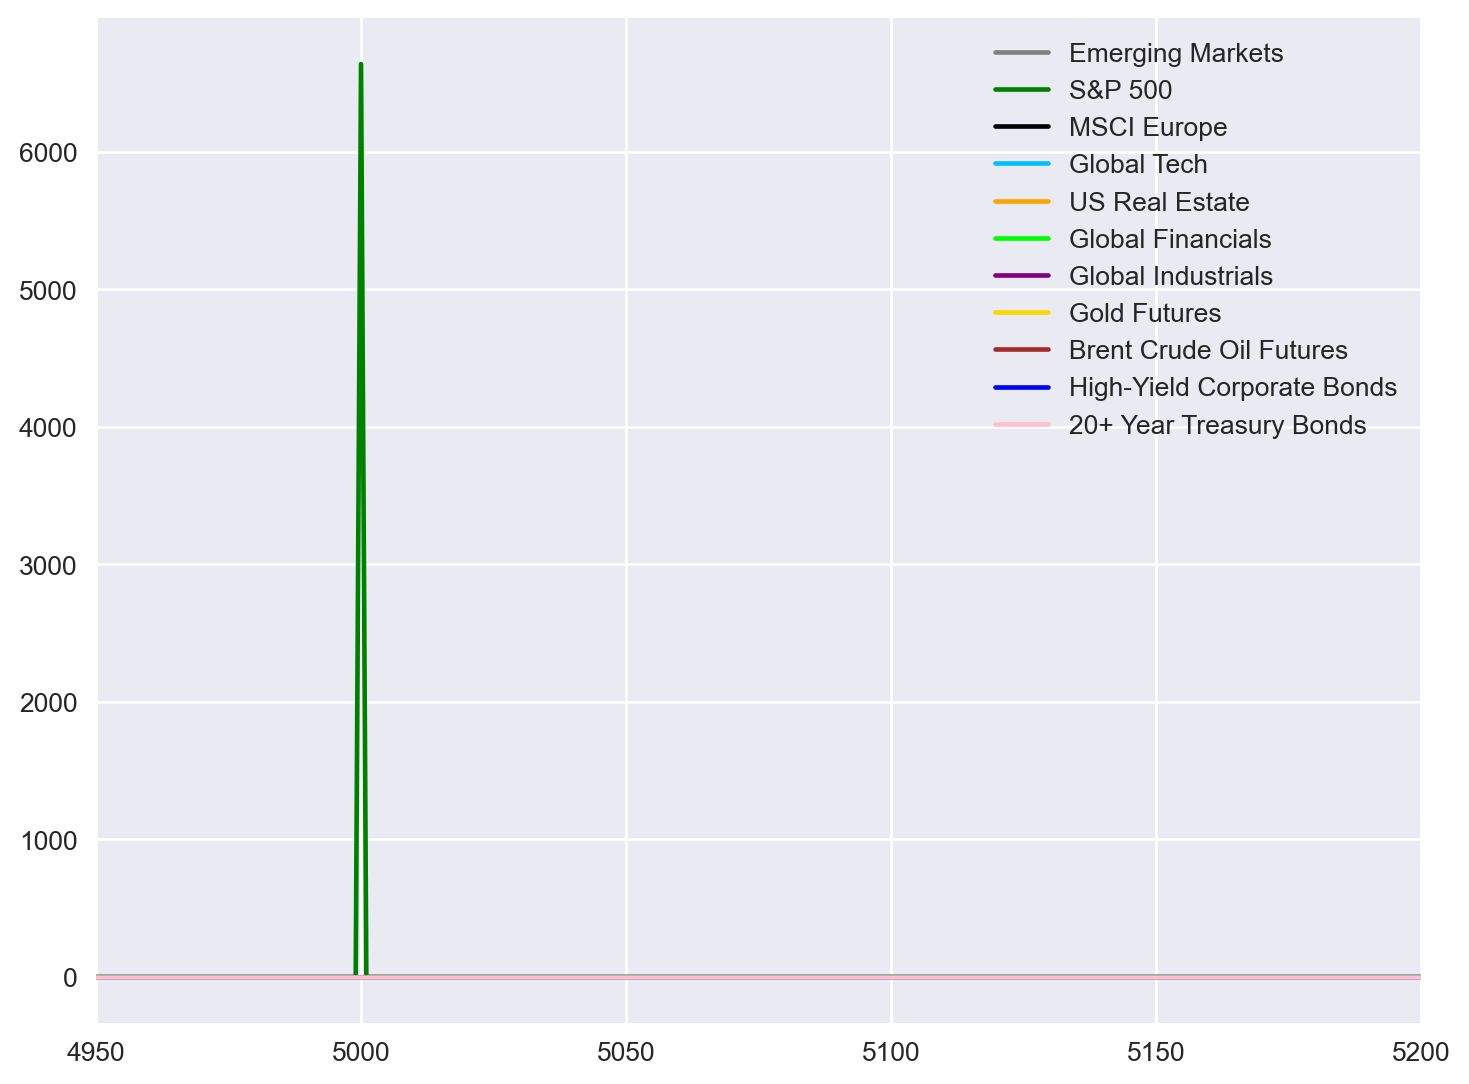

In [72]:
spread=200
t=10000
#plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax.plot(irf_sigma_ARCH)
ax.set_xlim(int(t/2-50),int(t/2+spread))
ax.legend(asset_names, loc='upper right')
#ax.set_xlabel('Returns') 
#ax.set_ylabel('Probability Density',loc='top', rotation = 0, labelpad = -110) 

**Laver figur til GARCH(1,1)**

In [45]:
coef_GARCH, residuals_GARCH, sigmas_GARCH= GARCH_MODEL("sGARCH",(1,1))

In [86]:
irf_weights_GARCH,irf_sigma_GARCH=IRF_maker("sGARCH11",10000,1,-15,coef_GARCH, residuals_GARCH, sigmas_GARCH)

[[0.10226279]
 [0.1689653 ]
 [0.12137549]
 [0.12242291]
 [0.11983982]
 [0.12549558]
 [0.12255347]
 [0.03381058]
 [0.08222635]
 [0.16814946]
 [0.06638544]]
[[0.06217886]
 [0.10031051]
 [0.06827837]
 [0.12706921]
 [0.08680731]
 [0.08120376]
 [0.0830226 ]
 [0.04060519]
 [0.05743953]
 [0.03623341]
 [0.02646141]]


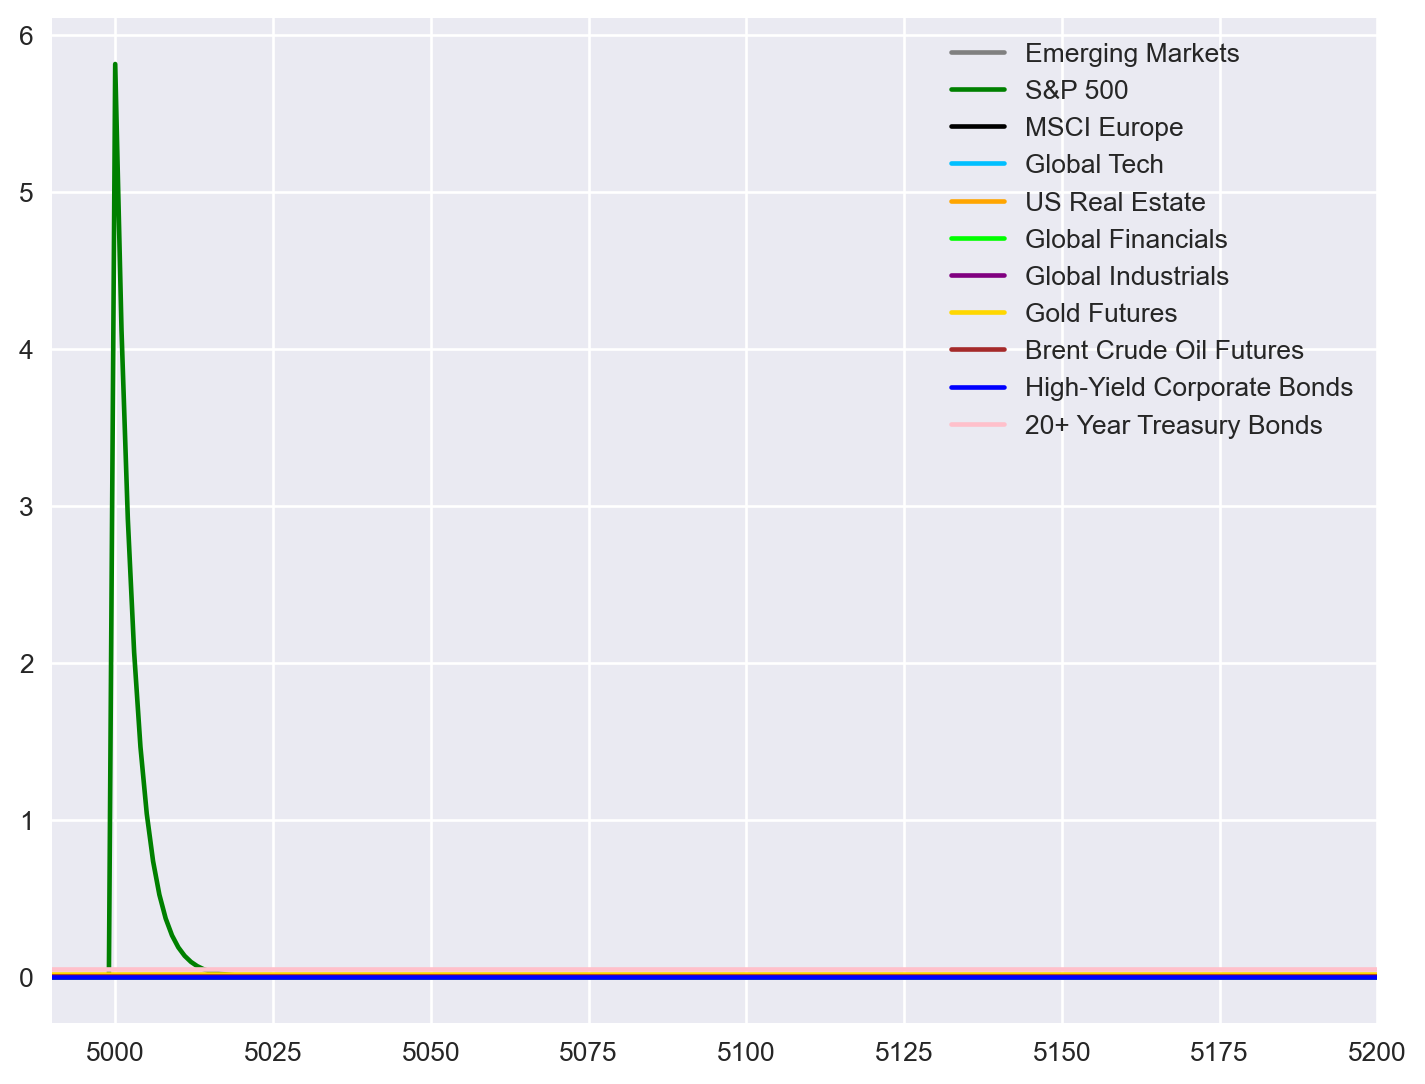

In [64]:
spread=200
t=10000
#plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax.plot(irf_sigma_GARCH)
ax.set_xlim(int(t/2-10),int(t/2+spread))
ax.legend(asset_names, loc='upper right')
#ax.set_xlabel('Returns') 
#ax.set_ylabel('Probability Density',loc='top', rotation = 0, labelpad = -110) 

**Laver figur til GJR-GARCH(1,1)**

In [51]:
coef_GJRGARCH, residuals_GJRGARCH, sigmas_GJRGARCH= GARCH_MODEL("gjrGARCH",(1,1))

In [52]:
irf_weights_GJRGARCH,irf_sigma_GJRGARCH=IRF_maker("gjrGARCH11",10000,1,-15,coef_GJRGARCH, residuals_GJRGARCH, sigmas_GJRGARCH)

gjrGARCH11 detected


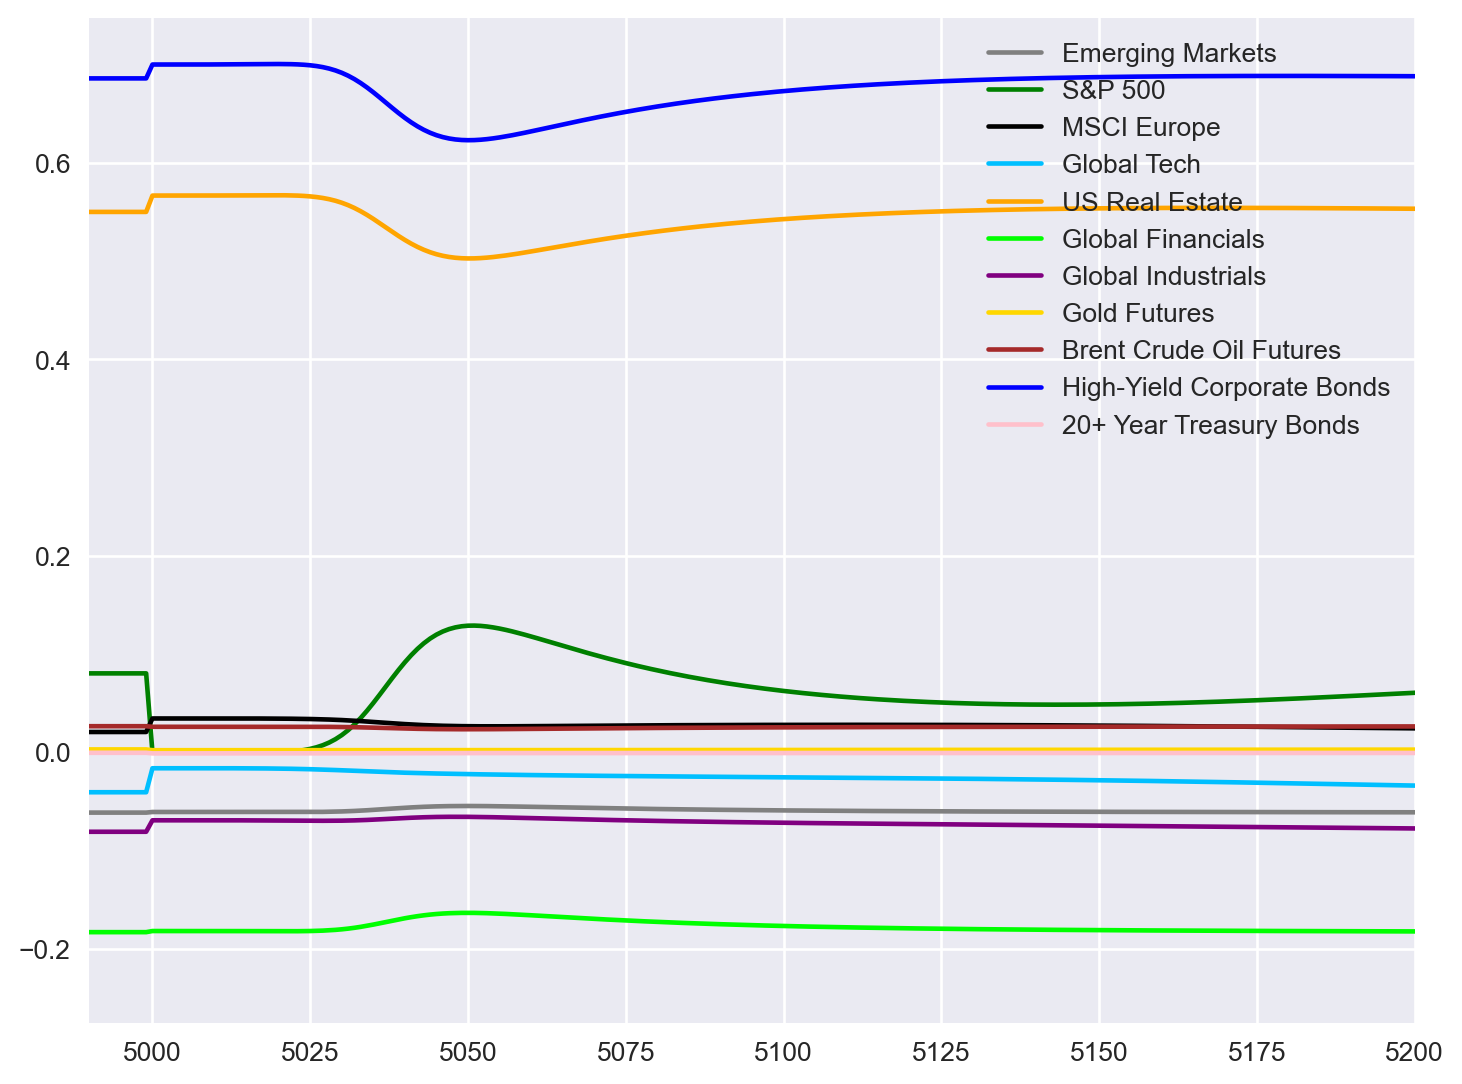

In [55]:
spread=200
t=10000
#plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax.plot(irf_weights_GJRGARCH)
ax.set_xlim(int(t/2-10),int(t/2+spread))
ax.legend(asset_names, loc='upper right')
#ax.set_xlabel('Returns') 
#ax.set_ylabel('Probability Density',loc='top', rotation = 0, labelpad = -110) 